In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from dataset import Dataset, to_device
from model import NNSingleFeatureModel, tims_mse_loss
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import normalize_data
import random
from time import time
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', 999)
pd.set_option('display.precision', 10)

In [2]:
raw_data = {} # loads raw data and stores as a dict cache

def dataset_key(dataset='', validation=False):
    return dataset+('test' if validation else 'train')


def load_data(raw, dataset='', validation=False):
    '''
    Return dataframe matching data set and validation. Dictionary input will be updated.

    Parameters
    ----------
    raw : dict
        dictionary which caches the dataframes and will be updated accordingly

    dataset : str
        which dataset to use? valid input includes: empty str for full set, sample_, and secret_

    validation : bool
        load validation set? if true then use _test, otherwise use _train.  Note secret_ doesn't have _train
    '''
    key = dataset+('test' if validation else 'train')
    if key not in raw:
        print(f"Loading data to cache for: {key}")
        raw[key] = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/../t5_data/{key}.pkl')
    return raw[key]

In [3]:
def load_sub_model_with_config(train_config, model_configs, sub_model_key, X_count=0, force_recreate=False):
    path = train_config['model_path']
    prefix = train_config['model_prefix']
    model_config = model_configs[sub_model_key]
    f = f"{path}/{prefix}{sub_model_key}.pth"
    if os.path.exists(f) and not force_recreate:
        print("Loading existing model")
        checkpoint = torch.load(f)
        net = checkpoint['net']
        loss_func = checkpoint['loss_func']
        optimizer = checkpoint['optimizer']
        mean_losses = checkpoint['mean_losses']
        next_epoch = checkpoint['next_epoch']
    else:
        raise Exception('Model does not exist')
    return net, loss_func, optimizer, mean_losses, next_epoch

def save_model_with_config(train_config, sub_model_key, **kwargs):
    path = train_config['model_path']
    prefix = train_config['model_prefix']
    f = f"{path}/{prefix}{sub_model_key}.pth"
    torch.save(kwargs, f)

In [4]:
def predict(model, X, y, device='cpu'):
    pyt_device = torch.device(device)
    model.eval()
    X_tensor = torch.from_numpy(X.to_numpy()).float()
    nn_results = model(X_tensor).detach().numpy()
    return nn_results

In [5]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

In [6]:
train_config = {
    'dataset' : 'sample2_', # '', 'sample_', 'secret_'
    'model_prefix' : "TRY_2_", 
    'model_path' : f"{os.environ['GP_HIST_PATH']}/../t5_models",
    'device' : 'cpu',
}

In [7]:
%%time
test_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=train_config['dataset'],validation=True)).dropna()
ref_test, X_test, y_test = get_ref_X_y(test_df)
y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG', 'y_ARG_OF_PERICENTER_REG', 'y_REV_MA_REG']
y_test = y_test[y_cols]

Loading data to cache for: sample2_test
CPU times: user 1.33 s, sys: 1.68 s, total: 3.01 s
Wall time: 2.35 s


In [8]:
model_configs = {
    'y_INCLINATION': { 'feature_index': X_test.columns.get_loc('X_INCLINATION_1') },
    'y_ECCENTRICITY': { 'feature_index': X_test.columns.get_loc('X_ECCENTRICITY_1') },
    'y_MEAN_MOTION': { 'feature_index': X_test.columns.get_loc('X_MEAN_MOTION_1') },
    'y_RA_OF_ASC_NODE_REG': { 'feature_index': X_test.columns.get_loc('X_RA_OF_ASC_NODE_1') },
    'y_ARG_OF_PERICENTER_REG': { 'feature_index': X_test.columns.get_loc('X_ARG_OF_PERICENTER_1') },
    'y_REV_MA_REG': { 'feature_index': X_test.columns.get_loc('X_MEAN_ANOMALY_1') },
}

Loading existing model
MSELoss()


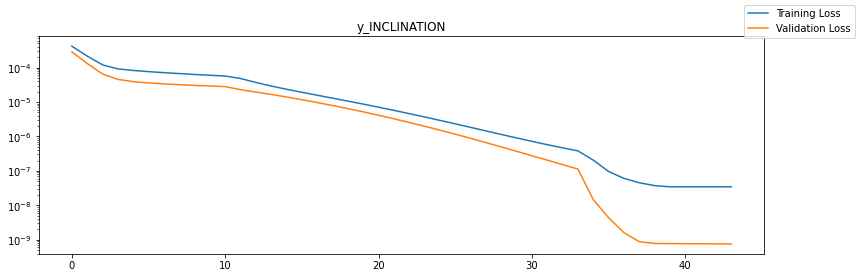

Epoch 44
    Test set MAE (L1) loss: 2.206454675716808e-05
    Test set MSE (L2) loss: 1.2088403899448759e-09
Test - Ground Truth (normalized):
Test - Prediction (normalized):
Test - X (normalized):
[(2.053872830359888e-07, 1.4570287198978349e-08), (9.603472558187358e-08, 4.363799099849075e-09), (6.067460089804119e-08, 1.6047171924604697e-09), (4.528126997815303e-08, 8.841184451213735e-10), (3.7312206451930687e-08, 7.815517122367055e-10), (3.4529223185452106e-08, 7.74917130463848e-10), (3.452608513561111e-08, 7.696331905115983e-10), (3.456472247585193e-08, 7.655044931276223e-10), (3.4520755355390064e-08, 7.620624409288013e-10), (3.455963329329612e-08, 7.591381967486655e-10)]
Loading existing model
MSELoss()


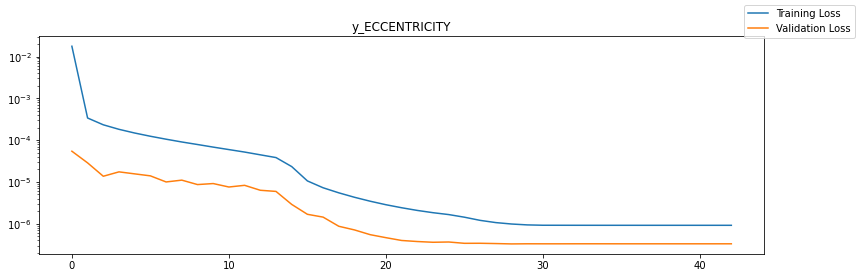

Epoch 43
    Test set MAE (L1) loss: 0.0003739046602598486
    Test set MSE (L2) loss: 9.623207720543338e-07
Test - Ground Truth (normalized):
Test - Prediction (normalized):
Test - X (normalized):
[(9.149286236727119e-07, 3.3030457302629657e-07), (9.145581825701751e-07, 3.3017582268257684e-07), (9.144787305885382e-07, 3.298479285263056e-07), (9.143816634293945e-07, 3.2990745069128025e-07), (9.140538940968365e-07, 3.2989523646165253e-07), (9.143375999363248e-07, 3.2989010634310034e-07), (9.142960833106214e-07, 3.298838961995898e-07), (9.140231782918386e-07, 3.2987482256885414e-07), (9.143069299554541e-07, 3.298445818700202e-07), (9.142103758652778e-07, 3.299049993188419e-07)]
Loading existing model
MSELoss()


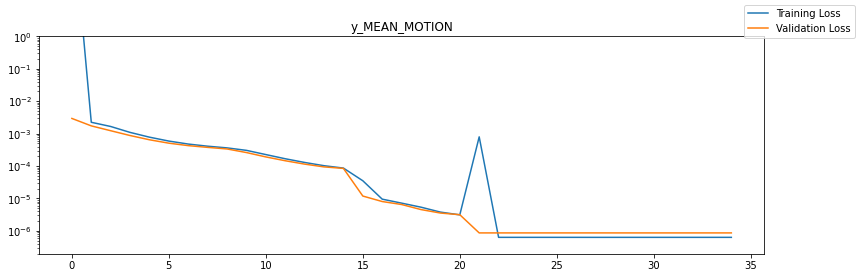

Epoch 35
    Test set MAE (L1) loss: 0.00019345381235459213
    Test set MSE (L2) loss: 1.1461894500040897e-06
Test - Ground Truth (normalized):
Test - Prediction (normalized):
Test - X (normalized):
[(6.31815983094952e-07, 8.655975428492216e-07), (6.318639036673118e-07, 8.653618922390852e-07), (6.311286018540133e-07, 8.659076696306199e-07), (6.315492648231739e-07, 8.653537750496249e-07), (6.317402909008802e-07, 8.655335564457443e-07), (6.316558140432041e-07, 8.65480866149174e-07), (6.316270696453047e-07, 8.654155437984709e-07), (6.317295311640095e-07, 8.65533985435921e-07), (6.317389762790495e-07, 8.656006212756243e-07), (6.317781523864659e-07, 8.657459881687503e-07)]
Loading existing model
MSELoss()


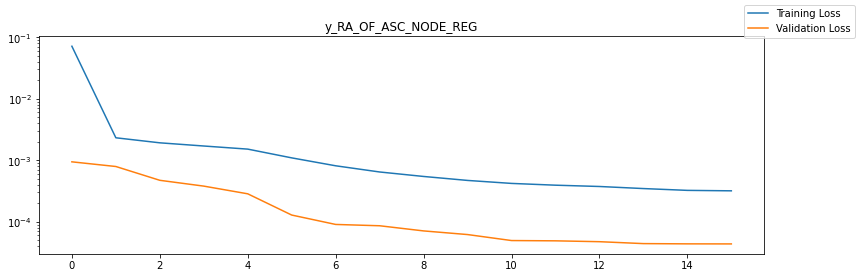

Epoch 16
    Test set MAE (L1) loss: 0.004352165370931933
    Test set MSE (L2) loss: 4.288953534243756e-05
Test - Ground Truth (normalized):
Test - Prediction (normalized):
Test - X (normalized):
[(0.0008133991193077758, 9.040033546625637e-05), (0.0006450311064035812, 8.604693201570106e-05), (0.0005453608570574109, 7.094080501701683e-05), (0.0004700267253615971, 6.188421217042819e-05), (0.0004203190648534659, 4.9446693343010596e-05), (0.0003932881677453792, 4.892877456898402e-05), (0.00037458501479624467, 4.737883890421861e-05), (0.00034661153209195034, 4.4098192250073354e-05), (0.0003238910050530151, 4.369172191737951e-05), (0.00031845542638902217, 4.35896873958492e-05)]
Loading existing model
No data for y_ARG_OF_PERICENTER_REG
Loading existing model
<function tims_mae_loss at 0x7fbc07834160>


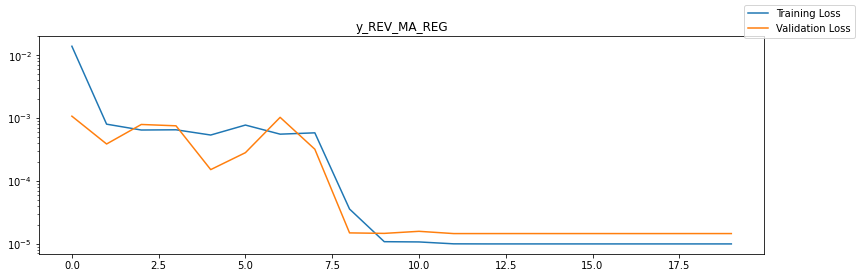

Epoch 20
    Test set MAE (L1) loss: 0.0010501508913407
    Test set MSE (L2) loss: 1.1246770794506872e-05
Test - Ground Truth (normalized):
Test - Prediction (normalized):
Test - X (normalized):
[(1.0678970223763514e-05, 1.5765482917881206e-05), (9.959393351509888e-06, 1.4510140934882137e-05), (9.930724470563572e-06, 1.4510072527887782e-05), (9.931203990339208e-06, 1.451614272290109e-05), (9.931106835200763e-06, 1.4510243155590225e-05), (9.930616863773305e-06, 1.4516460266479822e-05), (9.931400054282682e-06, 1.4510140934882137e-05), (9.931954916398418e-06, 1.4510072527887782e-05), (9.931125803943852e-06, 1.4516128170985862e-05), (9.931928345083597e-06, 1.4516340343107004e-05)]


,y_INCLINATION,y_INCLINATION,X_INCLINATION_1,y_ECCENTRICITY,y_ECCENTRICITY,X_ECCENTRICITY_1,y_MEAN_MOTION,y_MEAN_MOTION,X_MEAN_MOTION_1,y_RA_OF_ASC_NODE_REG,y_RA_OF_ASC_NODE_REG,X_RA_OF_ASC_NODE_1,y_REV_MA_REG,y_REV_MA_REG,X_MEAN_ANOMALY_1
371188,0.4602911111,0.4602679014,0.4602883333,0.0171832,0.0168430470,0.0169908,0.2888675989,0.2889500558,0.2888471909,0.7407500000,0.7393699288,0.7688652778,2.0619162284,2.0618770123,0.4646900000
494867,0.4603094444,0.4602783918,0.4603016667,0.0188704,0.0186414104,0.0187964,0.2911367703,0.2912037671,0.2911009086,0.5355308333,0.5337193608,0.5649080556,2.1543245525,2.1543564796,0.7858558333
1071676,0.5501272222,0.5501290560,0.5501344444,0.0356040,0.0358042009,0.0359132,0.3113907806,0.3114956319,0.3113927371,0.6770155556,0.6721861959,0.6485416667,1.6122919877,1.6234029531,0.2992955556
270478,0.4606766667,0.4606837034,0.4606816667,0.0193936,0.0192711279,0.0193612,0.2826716309,0.2827703655,0.2826673977,-0.0062280556,0.0001671771,0.0121983333,1.3763476080,1.3763834238,0.8055711111
1036772,0.5462505556,0.5462345481,0.5462505556,0.0456572,0.0453924648,0.0455288,0.3286356320,0.3287347555,0.3286319177,0.1946572222,0.1905672252,0.1622377778,1.9746363117,1.9746260643,0.4263669444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737512,0.3944216667,0.3944375217,0.3944438889,0.0408336,0.0415447541,0.0416564,0.3475956069,0.3477086425,0.3476057029,-0.0395597222,-0.0286220219,0.0239830556,1.6958797562,1.6958907843,0.5827241667
348313,0.4606388889,0.4606191218,0.4606322222,0.0198236,0.0194367059,0.0195656,0.2897401623,0.2898312509,0.2897284320,0.7778766667,0.7773182988,0.8027650000,1.8429193580,1.8429253101,0.7898377778
47373,0.3459338889,0.3459596336,0.3459433333,0.1286568,0.1285225451,0.1285760,0.3733547006,0.3733223975,0.3732194000,0.5644969444,0.5709825754,0.6188727778,0.9891821636,0.9891436100,0.0310016667
1181270,0.5452638889,0.5452507734,0.5452572222,0.0494108,0.0500338748,0.0501456,0.4766342217,0.4755967259,0.4754938297,0.3278636111,0.3191302419,0.2948688889,1.8307809568,1.8301689625,0.6658038889


In [85]:
# Create or load all new sub models here if needed.
sample_idx = random.sample(list(X_test.index), 10000)
# sample_idx = X_test.index
all_models = {}
display_data = []
for sub_key in y_cols:
    # When new models are created, a dummy optimizer is used
    model, loss_func, optimizer, mean_losses, next_epoch = load_sub_model_with_config(train_config, model_configs, sub_key)
    all_models[sub_key] = (model, loss_func, optimizer, mean_losses, next_epoch)
    try:
        tl, vl = zip(*mean_losses)
    except:
        print(f"No data for {sub_key}")
        continue

    fig,ax = plt.subplots(figsize=(13,4))
    print(loss_func)
    ax.plot(tl, label="Training Loss")
    ax.plot(vl, label="Validation Loss")
    ax.set_title(sub_key)
#     print(ax.get_ylim())
    ax.set_yscale('log')
    ax.set_ylim((ax.get_ylim()[0], min(1,ax.get_ylim()[1])))
    fig.legend()
    plt.show()
    
    trained_model = model
    X_sample = X_test.loc[sample_idx]
    y_sample = y_test.loc[sample_idx][[sub_key]]
    y_sample_pred = predict(trained_model, X_sample, y_sample, device="cpu") # get predictions for each train
    y_sample_pred_df = pd.DataFrame(y_sample_pred, columns=y_sample.columns, index=y_sample.index)  # put results into a dataframe
    print(f'Epoch {next_epoch}')
    print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_sample, y_sample_pred_df)}')
    print(f'    Test set MSE (L2) loss: {mean_squared_error(y_sample, y_sample_pred_df)}')
    print("Test - Ground Truth (normalized):")
#     display(y_sample)
    print("Test - Prediction (normalized):")
#     display(y_sample_pred_df)
    print("Test - X (normalized):")
#     display(X_sample.iloc[:,model_configs[sub_key]['feature_index']:model_configs[sub_key]['feature_index']+1])
    display_data.append(y_sample)
    display_data.append(y_sample_pred_df)
    display_data.append(X_sample.iloc[:,model_configs[sub_key]['feature_index']:model_configs[sub_key]['feature_index']+1])
#     display(X_sample.iloc[:,model_configs[sub_key]['feature_index']:model_configs[sub_key]['feature_index']+1].values - y_sample_pred_df.values)
    print(mean_losses[-10:])
    
df = pd.concat(display_data, axis=1)
display(df)

In [69]:
# np.abs((df.y_REV_MA_REG.iloc[:,1] - df.y_REV_MA_REG.iloc[:,0])).describe()

AdamW optimizer
Decrease learning rate slowly over time
Decrease weight decay if both training and validation are decreasing similarly

In [84]:
# np.abs((df.y_REV_MA_REG.iloc[:,1] - df.y_REV_MA_REG.iloc[:,0])).quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 0.99, 0.999])

In [71]:
# (np.abs((((df.y_REV_MA_REG.iloc[:,1])*90*360) - ((df.y_REV_MA_REG.iloc[:,0])*90*360))) % 360)